**Explanations for MultiTaxi domain based on causal theory.**

Final project on FSTMA course, spring 2022

Andrew Elashkin swag@campus.technion.ac.il

#Introduction

This project is a part of the preliminary research that expanded the method proposed by Hanna Chockler et al. in [[1]](https://arxiv.org/abs/2103.03622)	 to the reinforcement learning domain. This work serves as a proof of concept for explanaitions of reinforcement learning policies and opens further research opportunities that were not possible before. Those opportunities are discussed in more detail in the future work tab.

This notebook focuses on the local explainability and specifically on explaining the reasoning behind the action RL policy performs on a given environment state and not on the chain of states between the initial state and final reward. A good example for our motivation will be a car going from point A to point B and never reaching the destination. The explanation for this case would be that the car have crashed, however that would not explain to the observer why did it happen. By looking on a fixed state and decision we can explain why the car crashed.


We define minimal explanation in image classification as a minimal subset of pixels of a given input image that is sufficient for the DNN to classify the image, where “sufficient” is defined as containing only this subset of pixels from the original image, with the other pixels set to the masking color. The explanation cannot be too small (or empty), as a too small subset of pixels would violate the sufficiency requirement, there could exist multiple explanations for a given input image.

Explanations for the results of image classifiers are typically based on or are given in the form of a ranking of the pixels, which is a numerical measure of importance: the higher the score, the more important the pixel is for the DNN’s classification outcome. A user-friendly explanation can then be a subset of highest-ranked pixels that is sufficient for the original classification outcome. Another way of assessing the quality of a ranking is to check how many of the high-ranked pixels (constituting an explanation) need to be masked before the classification generated by the DNN changes. Unfortunately, since the ranking is based on computing the degree of responsibility of each pixel, which is NP-complete, the task of producing an exact minimal explanation for given classifier and image is also NP-complete. This makes the naive combinatoric approach unfeasible.

The same approach can be applied for reinforcement learning policies than accept images as an input. We consider joint action space of the environment as a classification space, and the policy action as a predicted class. Simular ideas were proposed before in [[2]](https://arxiv.org/abs/1905.10958) and [[3]](https://arxiv.org/abs/1807.05887), but none of those works were focused on local explainability and pixel-ranking.




We will create a MultiTaxi environment, train a PPO model from SB3 on the image representation of that environment. After that, for any given state image $x$ and policy action $f(x) = \mathcal{A}$ we can calculate the degree of responsibility of each pixel $p_i$ of state image $x$ to create a heatmap $\mathcal{H}$ of the state and produce an explanation $\mathcal{E}$.

# System information

Prints system information of the Colab VM including RAM and GPU info

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Sep  6 17:28:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 27.3 gigabytes of available RAM



# Dependencies installation

This notebook was built to run on the clean virtual machine with only TensorFlow and PyTorch preinstalled. If you are running it on your local machine and not on Google Colab please skip this tab and use provided .yml file.

If you are running this on Google Colab please run the whole tab. It will pip install stable baselines, multi taxi, PIL and will connect google drive.

In [1]:
!pip install stable-baselines3[extra] "git+https://github.com/sarah-keren/multi_taxi"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/sarah-keren/multi_taxi to /tmp/pip-req-build-_ip6m3v2
  Running command git clone -q https://github.com/sarah-keren/multi_taxi /tmp/pip-req-build-_ip6m3v2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 180 kB 2.1 MB/s 
     |████████████████████████████████| 796 kB 24.0 MB/s 
     |████████████████████████████████| 1.5 MB 60.3 MB/s 
     |████████████████████████████████| 1.6 MB 75.6 MB/s 
     |████████████████████████████████| 5.9 MB 56.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for multi-taxi: filename=multi_taxi-0.2.0-py3-none-any.whl size=9217976 sha256=9e864b568f8a06df698ddd6555cf9a6c8072a6

In [2]:
from PIL import Image
def np_to_pil(img_arr):
    return Image.fromarray(img_arr)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
save_path = F"/content/drive/My Drive/Colab Notebooks/FSTMA/test4/" 

# Creating MultiTaxi environment

Reminder: MultiTaxi environment is modeled as a **Markov game** (with a factored state space representation) defined by the tuple $\langle \mathcal{X}, \mathfrak{A}, \mathfrak{P}, \mathfrak{R}, \gamma\rangle$ where:

$\mathcal{X}$ - the locations of taxis, passengers, and passenger destinations on the grid.

$\mathfrak{A} = \{\mathcal{A}^i\}_{i=1}^{n}$ - joint action space. $\mathcal{A}^i$ contains: up, down, left, right, pick-up and drop-off.

$\mathfrak{P}$- deterministic joint probability distribution.

$\mathfrak{R} = \{\mathcal{R}^i\}_{i=1}^{n}$ - reward functions. $\mathcal{R}^i$ assigns a big positive reward for dropping off a passenger at her destination and a negative reward at each time step.

$\gamma$ is a discount factor $\gamma \in [0, 1]$.

The code was built for the version 0.2.0 of MultiTaxi by Sarah Keren [[4]](https://github.com/sarah-keren/multi_taxi), but should work on any version that adheres to PettingZoo API.

At this moment we are interested in the simpliest case, so we create a simple single taxi instance on a small map with 2 passengers. All other parameters are listed below.

In [ ]:
from multi_taxi import single_taxi_v0, maps, ObservationType

single_taxi_env = single_taxi_v0.gym_env(
    num_passengers=2,
    max_fuel=None,
    has_standby_action=True,
    specify_passenger_pickup=True,
    pickup_only=True,
    domain_map=maps.SMALL_MAP,
    observation_type=ObservationType.IMAGE,
    field_of_view=[None],
    max_steps=100,
    initial_seed = 42
)

# observation given on reset, just like gym
obs = single_taxi_env.reset()
single_taxi_env.render()

Environment state can be observed with render() that renders the vector state representation. Note: this is observation is different from the image observation, that is used in the explanation part, since it is ASCII and not a PIL image.

In [ ]:
obs = single_taxi_env.reset()
single_taxi_env.render()

# Loading PPO Model from SB3

One of two models needs to be chosen, PPO showed better results, so I recommend running this tab.

In [ ]:
from stable_baselines3 import PPO

env = single_taxi_env

model = PPO('CnnPolicy', env, verbose=1)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


# Loading A2C model from SB3

If you already created PPO model this will overwrite it.

In [ ]:
from stable_baselines3 import A2C

env = single_taxi_env

model = A2C('CnnPolicy', env, verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


# Learn for X timesteps

In [ ]:
from stable_baselines3.common.callbacks import CheckpointCallback

checkpoint_callback = CheckpointCallback(save_freq=200000, save_path='/content/drive/My Drive/Colab Notebooks/FSTMA/test4/',
                                         name_prefix='rl_model')

model.learn(15000000, callback=checkpoint_callback)

Streaming output truncated to the last 5000 lines.
|    value_loss           | 184         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 94.2        |
|    ep_rew_mean          | -51.1       |
| time/                   |             |
|    fps                  | 243         |
|    iterations           | 3508        |
|    time_elapsed         | 29448       |
|    total_timesteps      | 7184384     |
| train/                  |             |
|    approx_kl            | 0.043655068 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.331      |
|    explained_variance   | 0.744       |
|    learning_rate        | 0.0003      |
|    loss                 | 111         |
|    n_updates            | 35070       |
|    policy_gradient_loss | 0.00982     |
|    value_loss           | 190         |
-------------------------

In [ ]:
model.learn(total_timesteps=2000000)
model.save(save_path)

env.render()

Streaming output truncated to the last 5000 lines.
|    approx_kl            | 0.06793058 |
|    clip_fraction        | 0.197      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.306     |
|    explained_variance   | 0.892      |
|    learning_rate        | 0.0003     |
|    loss                 | 89.7       |
|    n_updates            | 7390       |
|    policy_gradient_loss | -0.0322    |
|    value_loss           | 183        |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 63.6        |
|    ep_rew_mean          | 70.4        |
| time/                   |             |
|    fps                  | 245         |
|    iterations           | 741         |
|    time_elapsed         | 6173        |
|    total_timesteps      | 1517568     |
| train/                  |             |
|    approx_kl            | 0.043506674 |
|    clip_fraction        | 0.124   

# Loading pre-trained PPO model

This tab will download the pre-trained PPO model parameters from the cloud and create a model with those parameters.

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
model_import = drive.CreateFile({'id':'10w653UU93mBxKyseEm87-_H5V3KT6Lic'})

model_import.GetContentFile('test4.zip')

In [ ]:
from stable_baselines3 import PPO

env = single_taxi_env

model = PPO('CnnPolicy', env, verbose=1)

load_path = F"test4" 
model = PPO.load(load_path)

# Validating

This tab will load and let you validate the trained model. Environment is rendered after every action of the policy.

In [ ]:
load_path = F"/content/drive/My Drive/Colab Notebooks/FSTMA/test2" 

In [ ]:
model = PPO.load(load_path)

/usr/local/lib/python3.7/dist-packages/cloudpickle/cloudpickle.py:704: UserWarning: A pickle file created using an old (<=1.4.1) version of cloudpicke is currently being loaded. This is not supported by cloudpickle and will break in cloudpickle 1.7
  "will break in cloudpickle 1.7", category=UserWarning


In [ ]:
obs = env.reset()
for i in range(10):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    action
    env.render()
    if done:
      obs = env.reset()

+---------+
| : | : : |
| : | : : |
|P: : : : |
| | : | : |
| |P: | : |
+---------+
Taxi0-YELLOW: Fuel: inf, Location: (3, 0), Engine: ON, Collided: False, Step: 1/100, ALIVE
Passenger0-YELLOW: Location: (2, 0), Destination: (-1, -1)
Passenger1-RED: Location: (4, 1), Destination: (-1, -1)
Env done: False

+---------+
| : | : : |
| : | : : |
|P: : : : |
| | : | : |
| |P: | : |
+---------+
Taxi0-YELLOW: Fuel: inf, Location: (2, 0), Engine: ON, Collided: False, Step: 2/100, ALIVE
Passenger0-YELLOW: Location: (2, 0), Destination: (-1, -1)
Passenger1-RED: Location: (4, 1), Destination: (-1, -1)
Env done: False

+---------+
| : | : : |
| : | : : |
|P: : : : |
| | : | : |
| |P: | : |
+---------+
Taxi0-YELLOW: Fuel: inf, Location: (2, 0), Engine: ON, Collided: False, Step: 3/100, ALIVE
Passenger0-YELLOW: Location: (2, 0), Destination: (-1, -1)
Passenger1-RED: Location: (4, 1), Destination: (-1, -1)
Env done: False

+---------+
| : | : : |
| : | : : |
|P: : : : |
| | : | : |
| |P: | : |
+------

# DEEPCOVER

**Def. 1**: For an state image $x$ and policy action $f(x) = \mathcal{A}$, a pixel $p_i$ of $x$ is a cause of $\mathcal{A}$ iff there exists a subset $P_j$ of pixels of $x$ such that the following conditions hold:
*   **Condition 1:** $p_i \not\in P_j$;
*   **Condition 2:** Changing the color of any subset $P_j' \subseteq P_j$ to the masking color does not change the classification;
*   **Condition 3:** Changing the color of $P_j$ and the color of $p_i$ to the masking color changes the classification.

We call such $P_j$ a witness to the fact that $p_i$ is a cause of policy action $\mathcal{A}$.

Given an state image $x$ and the policy action $\mathcal{A}$, we can calculate the degree of responsibility of each pixel $p_i$ of state image $x$ by directly applying **Def. 1**, that is, by checking the **Condition 1**, **Condition 2**, and **Condition 3** for all subsets $P_j$ of pixels of $x$ and then choosing a smallest witness subset.

---




Algorithm 1. Computing Heatmap and Explanation $(x)$ \\

INPUT: policy $\mathcal{P}$, an input image $x$, a parameter $N \in \mathbb{N}$ \\
OUTPUT: heatmap $H$, an explanation $\mathcal{E}$ \\

1: $r_{p} \leftarrow 0$ for all pixels $p$ \\
2: for $c$ in 1 to $N$ do \\
3: $\quad \mathbb{P}^{x} \leftarrow$ sample a partition \\
4: $\quad R \leftarrow$ compositional\_responsibility $\left(\mathcal{P}, x, \mathbb{P}^{x}\right)$ \\
5: $\quad$ for each $P_{i, j} \in$ domain of $R$ do \\
6: $\quad \forall p \in P_{i, j}: r_{p} \leftarrow r_{p}+\frac{R\left(P_{i, j}\right)}{\left|P_{i, j}\right|}$ \\
7: $\quad$ end for \\
8: end for \\
9: pixel\_ranking $\leftarrow$ pixels from high $r_{p}$ to low \\
10: heat\_map $H$ $\leftarrow$ overlay $\left(x, pixel\_ranking\right)$ \\
11: $\mathcal{E} \leftarrow \emptyset$ \\
12: for each pixel $p_{i} \in$ pixel\_ranking do \\
13: $\quad \mathcal{E} \leftarrow \mathcal{E} \cup\left\{p_{i}\right\}$ \\
14: $\quad x^{\text {exp }} \leftarrow$ mask pixels of $x$ that are not in $\mathcal{E}$ \\
15: $\quad$ if $\mathcal{P}\left(x^{\text {exp }}\right)=\mathcal{P}(x)$ then \\
16: $\quad$ return $\mathcal{E}$ \\
17: $\quad$ end if \\
18: end for \\

First, we create a MultiTaxi environment we want our model to run on. Note, that it should be the same dimentions as the one the policy was trained on, otherwise it won't be compatible.

In [ ]:
#To run a model trained in this notebook use this path
#load_path = F"/content/drive/My Drive/Colab Notebooks/FSTMA/test2" 

#To load a pre-trained model from cloud
load_path = F"test4" 

model = PPO.load(load_path)

/usr/local/lib/python3.7/dist-packages/cloudpickle/cloudpickle.py:704: UserWarning: A pickle file created using an old (<=1.4.1) version of cloudpicke is currently being loaded. This is not supported by cloudpickle and will break in cloudpickle 1.7
  "will break in cloudpickle 1.7", category=UserWarning


In [ ]:
from multi_taxi import single_taxi_v0, maps, ObservationType

single_taxi_env = single_taxi_v0.gym_env(
    num_passengers=2,
    max_fuel=None,
    has_standby_action=True,
    specify_passenger_pickup=True,
    pickup_only=True,
    domain_map=maps.SMALL_MAP,
    observation_type=ObservationType.IMAGE,
    field_of_view=[None],
    max_steps=100,
    initial_seed = 42
)

# observation given on reset, just like gym
obs = single_taxi_env.reset()
single_taxi_env.render()

+---------+
| : | : : |
| : | : :P|
| : : : : |
| | : | : |
| | : | :P|
+---------+
Taxi0-YELLOW: Fuel: inf, Location: (2, 3), Engine: ON, Collided: False, Step: 0/100, ALIVE
Passenger0-YELLOW: Location: (1, 4), Destination: (-1, -1)
Passenger1-RED: Location: (4, 4), Destination: (-1, -1)
Env done: False



Then we need to save the observation as an image, so we can use it to produce an explanation

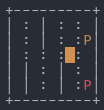

In [ ]:
taxi_image = np_to_pil(obs)
taxi_image

In [ ]:
taxi_image.size

(104, 110)

We clone the Deepcover tool (some code snippets and explanation below):

In [ ]:
!git clone -b x https://github.com/nce11/deepcover.git

Cloning into 'deepcover'...
remote: Enumerating objects: 5334, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 5334 (delta 46), reused 16 (delta 16), pack-reused 5267
Receiving objects: 100% (5334/5334), 122.37 MiB | 23.20 MiB/s, done.
Resolving deltas: 100% (156/156), done.
Checking out files: 100% (5071/5071), done.


In [ ]:
%cd /content/deepcover/

/content/deepcover


In [ ]:
from pathlib import Path
Path("data/taxi").mkdir(parents=True, exist_ok=True)

taxi_image.save("data/taxi/taxi_1.jpg")

In [ ]:
taxi_model = model

Deepcover was initially built for image classifiers, so it does not adhere to Gym or PettingZoo API. In order to make it work with SB3 model that follows the Gym API we need to prepare the image representing the state and the policy to satisfy the tensorflow API.

In [ ]:
#SB3 predict

from keras.preprocessing import image
from keras.applications import vgg16
from keras.applications.vgg16 import VGG16
from keras.applications import inception_v3, mobilenet, xception
from keras.models import load_model
import matplotlib.pyplot as plt
import csv

import argparse
import os
import numpy as np

import sys  
sys.path.insert(0, '/content/deepcover/src')

from utils import *
from to_explain import *
from comp_explain import *


#Setting up input dimentions
img_rows, img_cols, img_channels = 104, 110, 3
dnn = model

#Auxilary class to pass the computational arguments
class Argss:
  def __init__(self, testgen_iter):
    self.inputs = 'data/taxi/'
    self.outputs = 'outs'
    self.top_classes = 1
    self.adv_ub = 1.
    self.adv_lb = 0.
    self.adv_value = 234
    self.testgen_factor = 0.2
    self.testgen_size = 2000
    self.testgen_iter = testgen_iter
    self.causal = True
    self.mobilenet = False
    self.mnist = False
    self.grayscale = False
    self.measure = None

args = Argss(5)

print(args.inputs)


#Input state image preparation 
fnames=[]
xs=[]
if args.inputs!='-1':
  for path, subdirs, files in os.walk(args.inputs):
    for name in files:
      fname=(os.path.join(path, name))
      if fname.endswith('.jpg') or fname.endswith('.png') or fname.endswith('.JPEG'):
          if args.grayscale is True or args.mnist:
            x=image.load_img(fname, target_size=(img_rows, img_cols), color_mode = "grayscale")
            x=np.expand_dims(x,axis=2)
          else: 
            x=image.load_img(fname, target_size=(img_rows, img_cols))
          x=np.expand_dims(x,axis=0)
          xs.append(x)
          fnames.append(fname)
else:
  raise Exception ('What do you want me to do?')

xs=np.vstack(xs)
xs = xs.reshape(xs.shape[0], img_rows, img_cols, img_channels)
print ('\n[Total data loaded: {0}]'.format(len(xs)))


#Creating eobj that holds all computational arguments, number of iterations, policy, state image and SB3 flag that points to RL policy
eobj=explain_objectt(dnn, xs)
eobj.outputs= 'outs'
eobj.top_classes= 1
eobj.adv_ub= 1.
eobj.adv_lb= 0.
eobj.adv_value= 234
eobj.testgen_factor= 0.2
eobj.testgen_size= 2000
eobj.testgen_iter= 2
eobj.vgg16= False
eobj.mnist= False
eobj.cifar10= False
eobj.inception_v3= False
eobj.xception= False
eobj.mobilenet= False
eobj.attack= False
eobj.text_only= False
eobj.normalized= False
eobj.x_verbosity= 0
eobj.fnames=fnames
eobj.occlusion_file= None
eobj.sb3= True
measures = []
if not args.measure=='None':
    measures.append(args.measure)
else: measures = ['tarantula', 'zoltar', 'ochiai', 'wong-ii']
eobj.measures=measures


data/taxi/

[Total data loaded: 1]


This is the cell, where iterative computation is done. The computation is exactly as described in **Algorithm 1**:


[To explain: Causal Explanation is used]
2
  #### [Iter 0: Start Causal Refinement...]
  #### [Causal Refinement Done... Time: 15 seconds]
  #### [Saved Heatmap: outs/causal-2022-09-10-22-22-15.741530/heatmap_iter0.png]
  #### [Saving into outs/causal-2022-09-10-22-22-15.741530/iter0]
  #### [Done]
  #### [Iter 1: Start Causal Refinement...]
  #### [Causal Refinement Done... Time: 11 seconds]
  #### [Saved Heatmap: outs/causal-2022-09-10-22-22-15.741530/heatmap_iter1.png]
  #### [Saving into outs/causal-2022-09-10-22-22-15.741530/iter1]
  #### [Done]


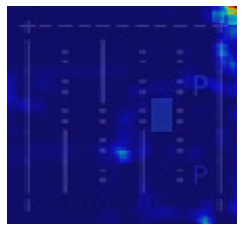

In [ ]:
comp_explain(eobj)

We do iterative Causal refinment by splitting the image into 4 randomly chosen parts and then iteratevly calculating the compositional_responsibility until the stopping condition is reached. 

    for i in range(0,eobj.testgen_iter):
        print ('  #### [Iter {0}: Start Causal Refinement...]'.format(i))
        heatMap=np.zeros(x.shape) # initialise an all-zero heatmap
        frags=2 #3 ## 3x3 is the limit an exhuastive search can handle
        x1, x2, y1, y2=0, int(x.shape[0]), 0, int(x.shape[1])
        totScore = 10000.
        #heatMap=np.ones(x.shape) * (totScore / heatMap.size)
        node=nodet(heatMap, frags, x1, x2, y1, y2, x, y, totScore, mask_value=eobj.adv_value, depth=0)
        # to call the recursive 'explain' method
        start = time.time()
        res_heatMap=compositional_causal_explain(node, eobj)
        end = time.time()
        print ('  #### [Causal Refinement Done... Time: {0:.0f} seconds]'.format(end-start))

After calculating responsibility for each of the pixels we can update the heatmap by merging the map of a current iteration with the res_heatMap, that averages the responsibility over all previous iterations.

        ## update res_heatMap
        res_heatMap = hmap/len(hmaps)
        smooth = np.ones(res_heatMap.shape)
        sI = res_heatMap.shape[0]
        sJ = res_heatMap.shape[1]
        sd = 3 #5 2
        for si in range(0, res_heatMap.shape[0]):
            for sj in range(0, res_heatMap.shape[1]):
                for sk in range(0, 3):
                    smooth[si][sj][sk] = np.mean(res_heatMap[np.max([0, si-sd]):np.min([sI, si+sd]), np.max([0,sj-sd]):np.min([sJ, sj+sd]), sk])


        res_heatMap = smooth
        res_heatMap = np.array((res_heatMap/res_heatMap.max())*255)
      

Then we continue this process until the completion. Number of iterations is set by the user in the previous code cell.

# Results and further work

Current implementation of the causual explanations for RL domain is a validity proof for the method itself.  Although it is only the preliminary work, we have managed to get some insight in the PPO decision making process, that was previously unobtainable.

Here is an example of the results, that now can be obtained for the policies on MultiTaxi:

Initial image state representation:

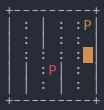

Heatmap for this representation:

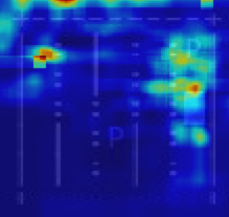

Top 25% pixels with highest degree of responsibility:

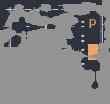

Our approach treats the policy as a blackbox, so it is policy-agnostic. Since we require only the policy itself and image of environment state it can also be applied to other RL environments. However, further research required for the method aplication in environments with only vector state representations. Those representations are are domain specific, so transfered application is limited.


Further steps:

1. Build better performing policies on MultiTaxi image represented environment. Compare those models, explore the environment and try figure out what distinguish good policy from bad one. 
2. Transfer the method from MultiTaxi to other GYM environments, such as ATARI or Mountain Car. Check if there is any transferable knowledge regarding explanations between different domains. 
3. Check how explanations depend on the training. Are explanations for the same policy, but trained differently, have something in common? 
